## Imports and Functions

In [184]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [ ]:
#https://github.com/ranaroussi/yfinance?tab=readme-ov-file

In [185]:
def calculate_daily_rate(A, n):
    """
    Calculate the daily interest rate given the future value (A) and the number of days (n).

    Parameters:
    A (float): The future value of the investment.
    n (int): The number of days over which the investment grows.

    Returns:
    float: The daily interest rate as a percentage.
    """
    daily_rate = (A ** (1/n)) - 1
    return daily_rate * 100  # Convert to percentage

In [186]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

## Preprocessing

In [187]:
# Define tickers
#tickers = ['SPY', 'MSFT', 'AAPL', 'AMZN']
tickers = ['TSLA']

In [188]:
# Set time period
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=30)

In [189]:
# Set previous month
prev_month_end_date = datetime.timedelta(days=30)
prev_month_start_date = prev_month_end_date - datetime.timedelta(days=30)

In [190]:
# Fetch and store data
all_data = []

for ticker in tickers:
    df = yf.Ticker(ticker).history(start=start_date, end=end_date, interval='5m')
    
    # Add a column for the ticker symbol
    df['Ticker'] = ticker
    
    # Append to the list
    all_data.append(df)

# Combine all data into a single DataFrame
combined_data = pd.concat(all_data)

# Reset the index to make it more coherent
combined_data.reset_index(inplace=True)

# Show the first few rows of the combined DataFrame
print(combined_data.head())

                   Datetime        Open        High         Low       Close  \
0 2023-12-04 09:30:00-05:00  235.750000  237.089996  234.919998  236.737000   
1 2023-12-04 09:35:00-05:00  236.795807  237.380005  234.679993  236.720001   
2 2023-12-04 09:40:00-05:00  236.714005  237.709900  235.830002  235.949997   
3 2023-12-04 09:45:00-05:00  235.971207  237.800003  235.830002  237.600006   
4 2023-12-04 09:50:00-05:00  237.578201  239.199997  236.820007  238.440002   

    Volume  Dividends  Stock Splits Ticker  
0  5822733        0.0           0.0   TSLA  
1  3626119        0.0           0.0   TSLA  
2  2811404        0.0           0.0   TSLA  
3  2358218        0.0           0.0   TSLA  
4  2639402        0.0           0.0   TSLA  


In [191]:
# Define the rolling window size
window_size = 780  # 10 days with 78 five min intervals

# Calculate rolling mean and standard deviation
# Using 'min_periods=1' allows the calculation even if the window is not fully populated
combined_data['Rolling_Mean'] = combined_data['Close'].rolling(window=window_size, min_periods=1).mean()
combined_data['Rolling_Std'] = combined_data['Close'].rolling(window=window_size, min_periods=1).std()


In [192]:
# Reverse the combined_dataFrame
combined_data_reversed = combined_data.iloc[::-1]

# Define the rolling window size (e.g., 1 day into the future)
window_size = 148

# Apply rolling max to find the maximum 'Close' price in the window
combined_data_reversed['Future_Max_Close'] = combined_data_reversed['Close'].rolling(window=window_size, min_periods=1).max()

# Reverse the combined_data back to its original order
combined_data = combined_data_reversed.iloc[::-1]

# Calculate the future return
combined_data['Future_Return_Percent'] = ((combined_data['Future_Max_Close'] - combined_data['Close']) / combined_data['Close']) * 100

# Drop any NaN values that might have been created in the process
combined_data = combined_data.dropna()

/var/folders/cm/xhb3ympj5s7fxrhdct80ny140000gn/T/ipykernel_76719/3467938567.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_reversed['Future_Max_Close'] = combined_data_reversed['Close'].rolling(window=window_size, min_periods=1).max()
/var/folders/cm/xhb3ympj5s7fxrhdct80ny140000gn/T/ipykernel_76719/3467938567.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Future_Return_Percent'] = ((combined_data['Future_Max_Close'] - combined_data['Close']) / combined_data['Close']) 

(array([542., 283., 339., 153.,  29.,  26.,  44.,  22.,  19.,  24.]),
 array([ 0.        ,  1.10547288,  2.21094577,  3.31641865,  4.42189154,
         5.52736442,  6.63283731,  7.73831019,  8.84378308,  9.94925596,
        11.05472885]),
 <BarContainer object of 10 artists>)

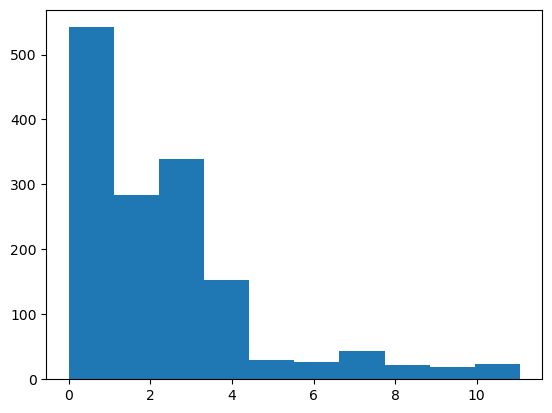

In [193]:
plt.hist(combined_data['Future_Return_Percent'])

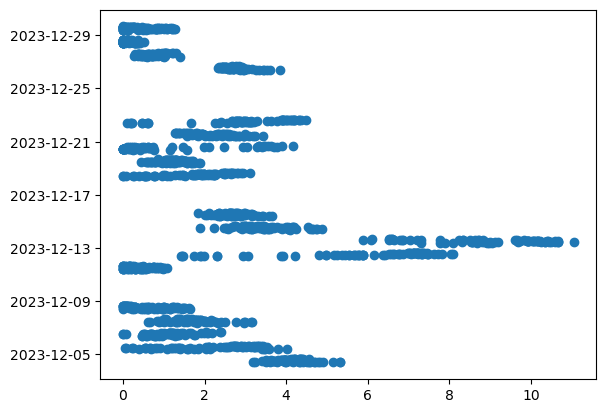

In [194]:
plt.scatter(combined_data["Future_Return_Percent"], combined_data['Datetime'])

In [195]:
Q1 = np.percentile(combined_data['Future_Return_Percent'], 25)
Q2 = np.percentile(combined_data['Future_Return_Percent'], 50)
Q3 = np.percentile(combined_data['Future_Return_Percent'], 75)
print(f'Quantile 1: {Q1} \nQuantile 2: {Q2} \nQuantile 3: {Q3}')

# Function to apply the labeling logic
def label_row(row):
    if row < Q1:
        return 0
    elif Q1 <= row < Q2:
        return 1
    elif Q2 <= row < Q3:
        return 2
    else:
        return 3

combined_data['labels'] = combined_data['Future_Return_Percent'].apply(label_row)

Quantile 1: 0.6358786458973331 
Quantile 2: 1.8062120221146787 
Quantile 3: 3.075002088058338


In [200]:
combined_data['Day_of_Week'] = combined_data['Datetime'].dt.day_name()

In [202]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform 'Day_of_Week'
encoded = encoder.fit_transform(combined_data[['Day_of_Week']])

# Create a DataFrame with encoded data
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Day_of_Week']))

combined_data = pd.concat([combined_data, df_encoded], axis=1)

combined_data = combined_data.drop('Day_of_Week', axis=1)

/Users/tdolan/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [215]:
combined_data

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Rolling_Mean,Rolling_Std,Future_Max_Close,Future_Return_Percent,labels,Day_of_Week_Friday,Day_of_Week_Monday,Day_of_Week_Thursday,Day_of_Week_Tuesday,Day_of_Week_Wednesday
1,2023-12-04 09:35:00-05:00,236.795807,237.380005,234.679993,236.720001,3626119.0,0.0,0.0,TSLA,236.728500,0.012020,246.180099,3.996324,3.0,0.0,1.0,0.0,0.0,0.0
2,2023-12-04 09:40:00-05:00,236.714005,237.709900,235.830002,235.949997,2811404.0,0.0,0.0,TSLA,236.468999,0.449550,246.180099,4.335708,3.0,0.0,1.0,0.0,0.0,0.0
3,2023-12-04 09:45:00-05:00,235.971207,237.800003,235.830002,237.600006,2358218.0,0.0,0.0,TSLA,236.751751,0.674184,246.180099,3.611150,3.0,0.0,1.0,0.0,0.0,0.0
4,2023-12-04 09:50:00-05:00,237.578201,239.199997,236.820007,238.440002,2639402.0,0.0,0.0,TSLA,237.089401,0.954427,246.180099,3.246140,3.0,0.0,1.0,0.0,0.0,0.0
5,2023-12-04 09:55:00-05:00,238.419693,239.130005,237.570007,237.830002,2019500.0,0.0,0.0,TSLA,237.212835,0.905627,246.180099,3.510952,3.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1476,2023-12-29 15:30:00-05:00,250.399994,250.419998,249.690308,249.690308,827603.0,0.0,0.0,TSLA,255.213850,3.681943,249.901001,0.084382,0.0,1.0,0.0,0.0,0.0,0.0
1477,2023-12-29 15:35:00-05:00,249.691101,250.050003,249.660004,249.901001,749854.0,0.0,0.0,TSLA,255.212685,3.683482,249.901001,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1478,2023-12-29 15:40:00-05:00,249.900101,250.089996,248.979996,249.169998,1256634.0,0.0,0.0,TSLA,255.211287,3.685570,249.169998,0.000000,0.0,1.0,0.0,0.0,0.0,0.0
1479,2023-12-29 15:45:00-05:00,249.179993,249.330002,248.889999,248.940002,985981.0,0.0,0.0,TSLA,255.209915,3.687707,248.940002,0.000000,0.0,1.0,0.0,0.0,0.0,0.0


In [214]:
nan_count = combined_data.isna().sum()
print("Number of NaNs in each column:\n", nan_count)

Number of NaNs in each column:
 Datetime                 0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
Dividends                0
Stock Splits             0
Ticker                   0
Rolling_Mean             0
Rolling_Std              0
Future_Max_Close         0
Future_Return_Percent    0
labels                   0
Day_of_Week_Friday       0
Day_of_Week_Monday       0
Day_of_Week_Thursday     0
Day_of_Week_Tuesday      0
Day_of_Week_Wednesday    0
dtype: int64


In [213]:
combined_data = combined_data.dropna()

## ML


In [216]:
# Split the dataset
# Features and Labels
X = combined_data[['Day_of_Week_Friday', 'Day_of_Week_Monday', 'Day_of_Week_Thursday',
                    'Day_of_Week_Tuesday', 'Day_of_Week_Wednesday', 'Rolling_Mean', 
                    'Rolling_Std', 'Open', 'High', 'Low',	'Close', 'Volume']] 
y = combined_data['labels']

# Calculate the split index
split_index = int(len(combined_data) * 0.8)

# Split the data into training and test sets
X_train = X[:split_index]
X_test_data = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

print(np.shape(X_train))
print(np.shape(y_train))

print(np.shape(X_test))
print(np.shape(y_test))

(1184, 12)
(1184,)
(312, 8)
(296,)


## Visualizations

In [ ]:
# Group data by ticker and isolate the first day
grouped_data = combined_data.groupby('Ticker').apply(lambda x: x[x['Datetime'].dt.date == x['Datetime'].dt.date.min()])

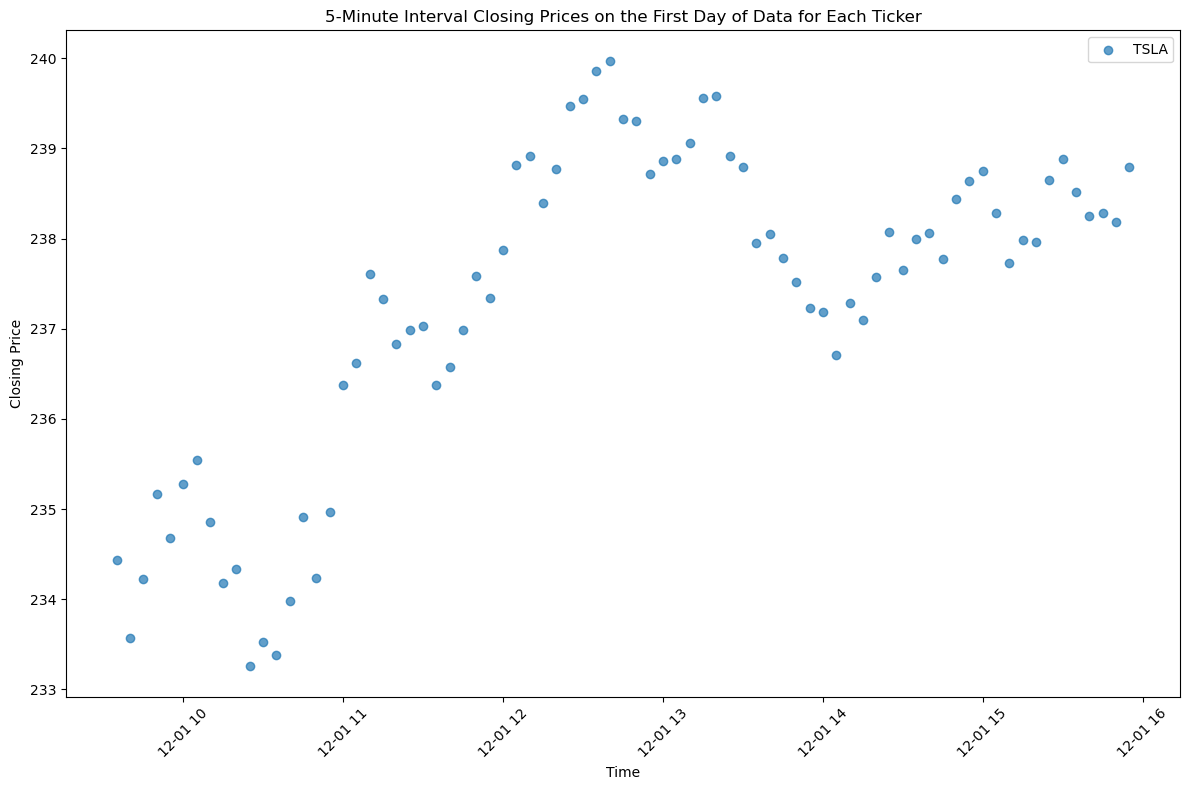

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

for ticker in tickers:
    data = grouped_data[grouped_data['Ticker'] == ticker]
    plt.scatter(data['Datetime'], data['Close'], label=ticker, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('5-Minute Interval Closing Prices on the First Day of Data for Each Ticker')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Assuming grouped_data is your DataFrame
# Loop through each ticker and standardize the 'Close' values
for ticker in grouped_data['Ticker'].unique():
    # Isolating the ticker's data
    ticker_data = grouped_data[grouped_data['Ticker'] == ticker]
    
    # Calculate mean and standard deviation for the 'Close' column
    mean = ticker_data['Close'].mean()
    std = ticker_data['Close'].std()
    # Calculate mean and standard deviation for the 'Volume' column
    mean_volume = ticker_data['Volume'].mean()
    std_volume = ticker_data['Volume'].std()

    # Apply Z-score standardization
    grouped_data.loc[grouped_data['Ticker'] == ticker, 'Z_Close'] = (ticker_data['Close'] - mean) / std
    grouped_data.loc[grouped_data['Ticker'] == ticker, 'Z_Volume'] = (ticker_data['Volume'] - mean_volume) / std_volume
# Display the updated DataFrame
print(grouped_data.head())

                          Datetime        Open        High         Low  \
Ticker                                                                   
TSLA   1 2023-12-01 09:35:00-05:00  233.039902  234.750000  231.899994   
       2 2023-12-01 09:40:00-05:00  234.381500  235.190002  232.669998   
       3 2023-12-01 09:45:00-05:00  233.533493  234.889999  233.251205   
       4 2023-12-01 09:50:00-05:00  234.180893  235.360001  232.979996   
       5 2023-12-01 09:55:00-05:00  235.162201  236.000000  234.160004   

               Close   Volume  Dividends  Stock Splits Ticker  Rolling_Mean  \
Ticker                                                                        
TSLA   1  234.429901  3910859        0.0           0.0   TSLA    233.699951   
       2  233.569901  3414481        0.0           0.0   TSLA    233.656601   
       3  234.225006  2791131        0.0           0.0   TSLA    233.798702   
       4  235.164993  3222689        0.0           0.0   TSLA    234.071960   
       

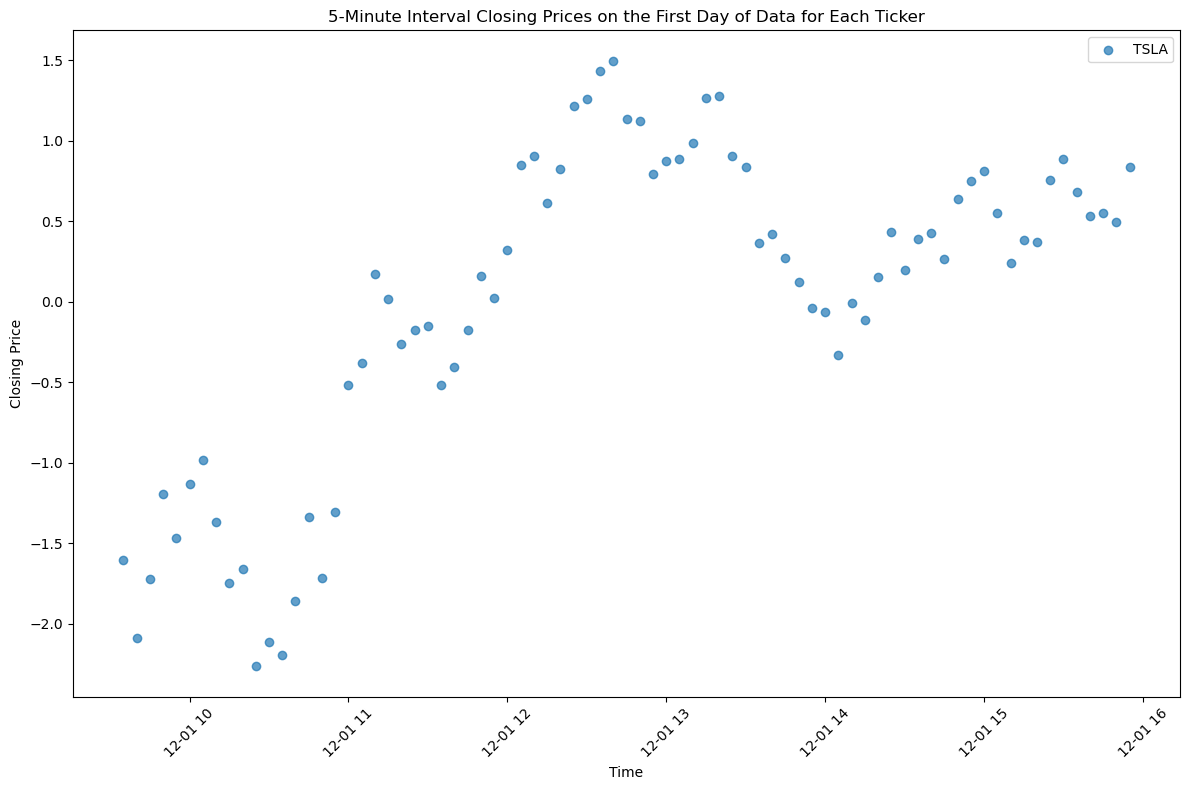

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

for ticker in tickers:
    data = grouped_data[grouped_data['Ticker'] == ticker]
    plt.scatter(data['Datetime'], data['Z_Close'], label=ticker, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('5-Minute Interval Closing Prices on the First Day of Data for Each Ticker')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()